# Análise do *dataset* Iris

Este notebook explora o *dataset* Iris, um conjunto de dados clássico em aprendizado de máquina e estatística. Ele contém 150 amostras de três espécies de flores do gênero *Iris*:
- *Iris setosa*
- *Iris versicolor*
- *Iris virginica*

Para cada amostra, foram medidas quatro características:
- Comprimento da sépala (*sepal length*) em cm
- Largura da sépala (*sepal width*) em cm
- Comprimento da pétala (*petal length*) em cm
- Largura da pétala (*petal width*) em cm

Este *dataset* é amplamente utilizado para tarefas de classificação, onde o objetivo é prever a espécie de uma flor com base em suas características físicas.

## Importando bibliotecas e dados...

Para essa tarefa, usaremos bibliotecas como o pandas, numpy, scikit-learn, etc. Portanto, faremos a importação dessas todas logo de início. Faço isso por preferência pessoal, visto que poderia importá-las conforme necessário nas células a seguir.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.optimizers import Adam
import os
import kagglehub

In [2]:
# Importação do dataset usando o KaggleHub.
arshid_iris_flower_dataset_path = kagglehub.dataset_download('arshid/iris-flower-dataset')
iris_csv_path = os.path.join(arshid_iris_flower_dataset_path, "IRIS.csv")

# Lendo-o em forma de dataframe
df = pd.read_csv(iris_csv_path)

df.head() # Primeiras 5 instâncias

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Visualização dos dados

Teremos a exibição, logo abaixo, de informações sobre os dados, tais quais a distribuição dos valores de seus atributos.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


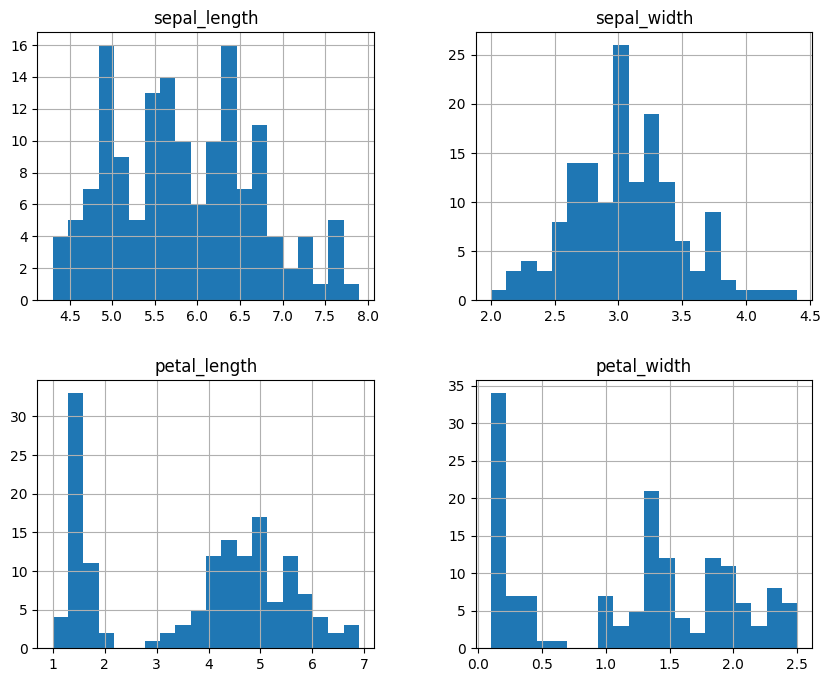

In [4]:
df.hist(column=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], bins=20, figsize=(10, 8))

plt.show()

## Pré-processamento dos dados

Agora começaremos o processo de limpeza e entendimento dos dados. Para essa tarefa, pretendo alcançar os seguintes objetivos:

- Manipular o dataset conforme meu objetivo final, que será prever a especificação de uma flor com base em seus atributos.

- Codificação de variáveis categóricas, como a *feature* "species" usando o Label Encoder.

- Normalização dos dados numéricos utilizando o MinMax. Para isso, antes, iremos **dividir** os dados entre teste e treinamento, algo que será útil posteriormente no treino do modelo.

In [5]:
# Codificação de variáveis categóricas (coluna "species")

le = sk.preprocessing.LabelEncoder()
df["species"] = le.fit_transform(df["species"])

df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [6]:
# Divisão dos dados entre treino e teste

X = df.values[:,:-1] # Todas as linhas e colunas (exceto a última)
Y = df.values[:,-1] # Todas as linhas da última coluna

train_set_X, test_set_X, train_set_Y, test_set_Y = train_test_split(X, Y, test_size=0.30, random_state=7) # 70% dos dados para treinamento

In [7]:
# Escalonamento dos dados numéricos

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(train_set_X)

X_test_scaled = scaler.transform(test_set_X) # Usa os parâmetros ajustados do conjunto de treino para transformar o conjunto de teste, isso evita viés

In [8]:
# Exibição dos dados após normalização

n = train_set_X.shape[1]  # número de atributos
m = train_set_X.shape[0]  # número de exemplos de treinamento

print("Número de atributos: n = " + str(n))
print("Número de exemplos de treinamento: m = " + str(m))
print("Formato do conjunto de treino X: " + str(train_set_X.shape))
print("Formato do conjunto de treino Y: " + str(train_set_Y.shape))
print("Formato do conjunto de teste X: " + str(test_set_X.shape))
print("Formato do conjunto de teste Y: " + str(test_set_Y.shape))

Número de atributos: n = 4
Número de exemplos de treinamento: m = 105
Formato do conjunto de treino X: (105, 4)
Formato do conjunto de treino Y: (105,)
Formato do conjunto de teste X: (45, 4)
Formato do conjunto de teste Y: (45,)


## Configuração do modelo

- Definição da estrutura da rede neural, sendo composta por:
    1. Entrada com quantidade de neurônios iguais à quantidade de atributos.
    2. Primeira camada oculta densa, com 64 unidades, usando a função de ativação *Leaky ReLU*. Essa camada será usada para configurar um *dropout* (estratégia que usarei para evitar *overfitting*, visto que o número de instâncias é relativamente pequena).
    3. Segunda camada oculta densa, já afetada pelo dropout da primeira. Ela é composta por 32 unidades, com a função de ativação *Leaky ReLU*. Essa camada também será usada para a criação de outro *dropout*.
    4. A terceira camada oculta densa conta com 16 unidades, também utilizando a função de ativação *Leaky ReLU*.
    5. Por fim, a camada de saída contém 3 neurônios, cada um representando uma das classes distintas do *dataset*. Essa camada usa a função de ativação *softmax*, que é adequada para problemas de classificação multiclasse, pois retorna uma probabilidade para cada classe, totalizando 1.

In [9]:
inputs = keras.Input(shape=(train_set_X.shape[1],))  # Mesma quantidade dos atributos
layer1 = keras.layers.Dense(units=64, activation='leaky_relu')(inputs)
dropout1 = keras.layers.Dropout(0.2)(layer1)
layer2 = keras.layers.Dense(units=32, activation='leaky_relu')(dropout1)
dropout2 = keras.layers.Dropout(0.2)(layer2)
layer3 = keras.layers.Dense(units=16, activation='leaky_relu')(dropout2)
outputs = keras.layers.Dense(units=3, activation="softmax")(layer3)  # Quantidade de classes diferentes

model = keras.models.Model(inputs=inputs, outputs=outputs)

In [10]:
# Informações da rede

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,979 (11.64 KB)

 Trainable params: 2,979 (11.64 KB)

 Non-trainable params: 0 (0.00 B)

## Execução do modelo preditivo

Agora vamos, enfim, utilizar os dados já organizados para o treinamento do nosso modelo. Nesse sentido, usaremos a rede neural artifical configurada logo acima. Usaremos algumas métricas diferentes, como a *sparse categorical crossentropy*, além da *accuracy*. O otimizador utilizado será o Adam, com uma taxa de aprendizado de 0,001.

In [11]:
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', keras.metrics.SparseCategoricalAccuracy()])

In [12]:
history = model.fit(train_set_X, train_set_Y, batch_size=32, epochs=50)

print(history.history)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3087 - loss: 1.2546 - sparse_categorical_accuracy: 0.3087
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4495 - loss: 1.0813 - sparse_categorical_accuracy: 0.4495 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4284 - loss: 1.0568 - sparse_categorical_accuracy: 0.4284 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5546 - loss: 0.9940 - sparse_categorical_accuracy: 0.5546 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5324 - loss: 0.9489 - sparse_categorical_accuracy: 0.5324 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6150 - loss: 0.9176 - sparse_categorical_accuracy: 0.6150 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6653 - loss: 0.8803 - sparse_categorical_accuracy: 0.6653 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6795 - loss: 0.8396 - sparse_categorical_accuracy: 0.6795 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━

## Avaliação do modelo

Para o avaliarmos, entenderemos seu desempenho de predição no conjunto de treino, antes de passarmos para a predição propriamente dita.

In [13]:
loss, acc, sparse_acc= model.evaluate(test_set_X, test_set_Y)

print("Loss: %.2f" % loss, "\nAccuracy: %.2f" % acc, "\nSparse Accuracy: %.2f" % sparse_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9748 - loss: 0.1848 - sparse_categorical_accuracy: 0.9748  
Loss: 0.17 
Accuracy: 0.98 
Sparse Accuracy: 0.98


## Predição

Se tratando da predição propriamente dita, exibiremos as classes com maior probabilidade indicadas pela função *softmax* e contabilizaremos os acertos e erros do modelo.

In [14]:
predictions = model.predict(test_set_X)

predicted_classes = [np.argmax(pred) for pred in predictions]  # Pega a classe com a maior probabilidade
correct_labels = [int(x) for x in test_set_Y]
num_correct = sum([1 for i in range(len(correct_labels)) if predicted_classes[i] == correct_labels[i]])

print("Número de acertos:", num_correct)
print("Total de exemplos:", len(correct_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Número de acertos: 44
Total de exemplos: 45
